In [1]:
import sys
sys.path.append("..")

from functools import reduce

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

from modules import Retina
from utils import array2img, img2array

sys.path.append("..")

import torch

import model
import utils

from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

import data_loader
from config import get_config


In [2]:
#load the model (code from load_checkpoint function in trainer.py):

config, unparsed = get_config()


filename = "../ckpt/ram_6_1x1_1_model_best.pth.tar"

ckpt = torch.load(filename) #model

# build RAM model
config, unparsed = get_config()

ram0 = model.RecurrentAttention(
    1,
    config.num_patches,
    config.glimpse_scale,
    1,
    config.loc_hidden,
    config.glimpse_hidden,
    config.std,
    config.hidden_size,
    10,
)

ram0.load_state_dict(ckpt["model_state"])

<All keys matched successfully>

In [3]:
print(" Model data:\n patch size: " + str(config.patch_size) + 
    "\n num_patches: " + str(config.num_patches)+
    "\n glimpse_scale: " + str(config.glimpse_scale)+
    "\n num_channels: " + str(1)+
    "\n loc_hidden: " + str(config.loc_hidden)+
    "\n glimpse_hidden: " + str(config.glimpse_hidden)+
    "\n std: " + str(config.std)+
    "\n hidden_size: " + str(config.hidden_size)+
    "\n num_classes: " + str(10))

 Model data:
 patch size: 1
 num_patches: 1
 glimpse_scale: 1
 num_channels: 1
 loc_hidden: 128
 glimpse_hidden: 128
 std: 0.05
 hidden_size: 256
 num_classes: 10


In [4]:
def reset():
    h_t = torch.zeros(
        1,
        config.hidden_size,
        dtype=torch.float,
        requires_grad=True,
    )
    l_t = torch.FloatTensor(
        1, 2).uniform_(-1, 1)
    l_t.requires_grad = True

    return h_t, l_t

In [6]:
normalize = transforms.Normalize((0.1307,), (0.3081,))
trans = transforms.Compose([transforms.ToTensor(), normalize])

dataset = datasets.MNIST("../data", train=False, download=True, transform=trans)


In [25]:
mnistImage, label = dataset[11]
mnistImage = mnistImage.unsqueeze(1)

#do 10 glimpses
h_t, l_t = reset()

loc_list = []
for t in range(5):
    # forward pass through model
    h_t, l_t, b_t, p = ram0(mnistImage, l_t, h_t)
    loc_list.append(l_t)

# last iteration
h_t, l_t, b_t, log_probas, p = ram0(mnistImage, l_t, h_t, last=True)

pred = log_probas.data.max(1, keepdim=True)[1][0][0].item()
print("Prediction: " + str(pred) + ", actual: " + str(label))

Prediction: 8, actual: 6


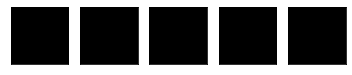

In [26]:
num_patches = config.num_patches
scale = config.glimpse_scale
patch_size = config.patch_size

glimpses = []
for loc in loc_list:
    ret = Retina(g=patch_size, k=num_patches, s=scale)
    glimpse = ret.foveate(mnistImage, loc).data.numpy()
    glimpse = np.reshape(glimpse, [1, num_patches, 1, patch_size, patch_size])
    glimpse = np.transpose(glimpse, [0, 1, 3, 4, 2])
    glimpses.append(glimpse)

    
fig, axs = plt.subplots(nrows=1, ncols=len(glimpses))
for i, ax in enumerate(axs.flat):
    axs[i].imshow(glimpses[i][0][0], cmap="gray")
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
plt.show()

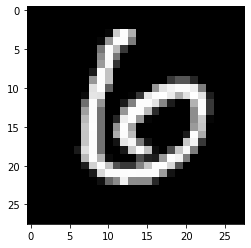

In [27]:
plt.imshow(mnistImage[0][0], cmap="gray")